# Attack

https://github.com/AI-secure/GMI-Attack

attack the private model use public data

private model is the segmentation net trained on GTA5

In [2]:
import torch
import torch.nn as nn
from models.deeplabv3 import DeepLabV3
from models.gan import Generator
from models.gan import Discriminator

from datasets.cityscapes import CityScapes
from torchvision import transforms as T
import torchvision.transforms.functional as F
#visualization 
from tqdm.notebook import tqdm

torch.Size([1, 3, 1024, 2048])
torch.Size([1, 1024, 2048])
['aachen_000000_000019_leftImg8bit']


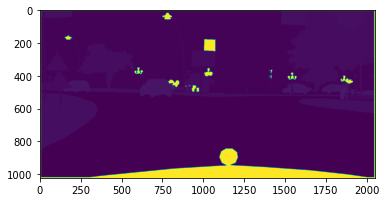

torch.Size([1, 1024, 2048])
[  0   1   2   5   7   8   9  10  11  12  13  18 255]



In [9]:

from configparser import Interpolation


def freeze(net):
    for p in net.parameters():
        p.requires_grad_(False) 

def unfreeze(net):
    for p in net.parameters():
        p.requires_grad_(True)
def attack(G:nn.Module,D:nn.Module,T:nn.Module,iden,lr = 1e-2, momentum=0.9, lamda=100, iter=1500,clip_range = 1)->torch.tensor:
    """_summary_

    Args:
        G (nn.Module): Generator
        D (nn.Module): Discriminator
        T (nn.Module): Source model-> segmentation network
        iden (tensor): segmentation result Tensor of (B H W) in 0~255 int
        lr (float, optional): learing rate update z. Defaults to 1e-2.
        momentum (float, optional): momentum. Defaults to 0.9.
        lamda (int, optional): hyper param for weight of iden loss, lamda*iden loss. Defaults to 100.
        iter (int, optional): update z iteration. Defaults to 1500.
        clip_range (int, optional): clip z to [-range, range]. Defaults to 1.

    Returns:
        tensor(cuda): _description_
    """
    ce = nn.CrossEntropyLoss(ignore_index=255)
    bs = iden.shape[0]
    b,h,w = iden.size()

    z = torch.randn(bs, G.z_dim,h//8,w//8).float()
    v = torch.zeros(bs, G.z_dim,h//8,w//8).float()
    z.requires_grad = True
    G.eval()
    D.eval()

    # inner loop:
    for i in tqdm(range(iter)):
        fake = G(z)
        label = D(fake)
        out = T(fake)['out'] # Deeplabv3

        if z.grad is not None:
            z.grad.data.zero_()
        
        prior_loss = - label.mean() # E( D (G(z)) )
        iden_loss = ce(out,iden) # B C H W <-> B H W
        total_loss = prior_loss + lamda * iden_loss
        total_loss.backward()

        # update z
        v_prev = v.clone()
        gradient = z.grad.data
        v = momentum * v - lr * gradient
        z = z + ( - momentum * v_prev + (1 + momentum) * v)
        z = torch.clamp(z.detach(), -clip_range, clip_range).float()
        z.requires_grad = True

        prior_Loss_val = prior_loss.item()
        iden_Loss_val = iden_loss.item()

    return z.detach()


#######
# Setting 
#######
device = torch.device("cuda")
output_dir = ''

#######
# load models
#######
# source model fix
source = DeepLabV3()
source.train()
freeze(source)
# s-> target model 
target = DeepLabV3().cuda()
target.train()
# Generator
z_dim = 256
generator = Generator(3,z_dim)
# Domain estimation
discriminator = Discriminator(3,z_dim)
discriminator.eval()
# z = rand n || attack

######
# load datas: Target city scape
######
root_dir = "F:\COMP90055\GMIDA\datas\CityScapes"
dataloader = CityScapes(root_dir,batch_size=1,split='train')
resize = T.Resize((256,512),interpolation=F.InterpolationMode.NEAREST) 

import numpy as np
import matplotlib.pyplot as plt
# image label image id
for image_id,image,label in tqdm(dataloader):
    print(image.size())
    print(label.size())
    print(image_id)
    label = label

    # label = resize(label)
    plt.imshow(label[0].numpy())
    plt.show()
    print(label.size())
    print(np.unique(label.numpy()))
    # z = attack(generator,discriminator,source,label)
    # G
    # z = torch.randn(4,z_dim,8,16)
    # fake = generator(z) # 
    # s_f = source(fake) # Use for MAE
    #             # hook BN for BNS ,back ward G

    # S_t = T(fake) # Use for MAE 
    # G.train()
    break
    # real = T(real)  # TAR loss use prob map calculate Square Max

